<a href="https://colab.research.google.com/github/HaqTetsuya/rusdi-prototype-1/blob/main/rusdi_prototype_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download dependancy
# Cell 1: Instalasi library yang diperlukan
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm deep-translator fuzzywuzzy


In [13]:
# @title import dependency, load drive, and github {"form-width":"20%"}
!git clone https://github.com/HaqTetsuya/rusdi-prototype-1.git

import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from google.colab import drive, files
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
#from tqdm import tqdm
from tqdm.auto import tqdm  # If you need both tqdm and tqdm.auto
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

drive.mount('/content/drive')
FName = "RusdiIntent2" #@param {type:"string"}

# Update MODEL_SAVE_PATH with user input
MODEL_SAVE_PATH = f"/content/drive/MyDrive/{FName}"


# Cell 4: Kelas Dataset untuk IndoBERT
class IntentDataset(Dataset):
    """Dataset untuk klasifikasi intent dengan IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)

        return item

fatal: destination path 'rusdi-prototype-1' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# @title load data

def load_csv_data(csv_path, label_encoder=None, show_distribution=False):
    """Memuat data intent dari file CSV. Bisa untuk train/test tanpa split."""
    print(f"\nMemuat data dari: {csv_path}")

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File tidak ditemukan: {csv_path}")

    df = pd.read_csv(csv_path)

    if 'text' not in df.columns or 'intent' not in df.columns:
        raise ValueError("Kolom 'text' dan 'intent' harus ada di CSV")

    if label_encoder is None:
        label_encoder = LabelEncoder()
        df['intent_encoded'] = label_encoder.fit_transform(df['intent'])
        intent_classes = label_encoder.classes_
        print(f"Label encoder baru dibuat dari data {csv_path}")
    else:
        df['intent_encoded'] = label_encoder.transform(df['intent'])
        intent_classes = label_encoder.classes_
        print(f"Menggunakan label encoder yang sudah ada")

    if show_distribution:
        intent_counts = df['intent'].value_counts()
        print("\nDistribusi intent:")
        for intent, count in intent_counts.items():
            print(f"  {intent}: {count}")

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")
        plt.xlabel("Intent")
        plt.ylabel("Jumlah Sampel")
        plt.title("Distribusi Intent")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.pie(intent_counts, labels=intent_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(intent_counts)))
        plt.title("Proporsi Intent")
        plt.tight_layout()
        plt.show()

    texts = df['text'].values
    labels = df['intent_encoded'].values

    return texts, labels, intent_classes, label_encoder


In [15]:
# @title  setup model IndoBERT
def setup_indobert_for_intent(num_labels):
    """Load model IndoBERT untuk klasifikasi intent"""

    print("Memuat model IndoBERT...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p1",
        num_labels=num_labels
    )
    print("Model berhasil dimuat")

    return model, tokenizer

In [28]:
# @title OOD
def enhanced_calibrate_ood(model, tokenizer, val_dataloader, save_path, temperature=1.0, percentile=80, margin=0.1):
    """
    Calibrate and save OOD thresholds with adjustable tolerance
    """
    print("Calibrating threshold for OOD detection...")
    thresholds = calibrate_ood_detection(model, tokenizer, val_dataloader,
                                        temperature=temperature,
                                        percentile=percentile,
                                        margin=margin)

    print(f"Energy threshold: {thresholds['energy_threshold']:.4f}")
    print(f"MSP threshold: {thresholds['msp_threshold']:.4f}")

    # Save thresholds
    save_ood_thresholds(thresholds, save_path)

    return thresholds

def calibrate_ood_detection(model, tokenizer, dataloader, temperature=1.0, percentile=70, margin=0.1):
    """
    Calibrate thresholds for OOD detection using in-distribution data
    with Energy-based and MSP (Maximum Softmax Probability) methods
    """
    device = next(model.parameters()).device
    model.eval()

    # For Energy method and MSP method
    energy_scores = []
    msp_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calibrating OOD detection"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits

            # Energy score (higher values for OOD)
            energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
            energy_scores.extend(energy.cpu().numpy())

            # MSP score (lower values for OOD)
            softmax_probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(softmax_probs, dim=1)
            msp_scores.extend(max_probs.cpu().numpy())

    # Calculate threshold for Energy with margin (make more tolerant)
    base_energy_threshold = np.percentile(energy_scores, percentile)
    # Apply margin to make more tolerant (increase threshold)
    energy_threshold = base_energy_threshold * (1 + margin)

    # Calculate threshold for MSP with margin
    base_msp_threshold = np.percentile(msp_scores, 100 - percentile)
    # Apply margin to make more tolerant (decrease threshold)
    msp_threshold = base_msp_threshold * (1 - margin)

    return {
        "energy_threshold": float(energy_threshold),
        "msp_threshold": float(msp_threshold)
    }

def predict_with_ood_detection(model, tokenizer, text, thresholds, temperature=1.0, tolerance_factor=1.0):
    """
    Predict with adjustable OOD detection tolerance
    """
    device = next(model.parameters()).device
    model.eval()

    # Apply the tolerance factor to thresholds
    energy_threshold = thresholds["energy_threshold"] * tolerance_factor
    msp_threshold = thresholds["msp_threshold"] / tolerance_factor if thresholds["msp_threshold"] else None

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Energy score
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
        energy_score = energy.item()

        # MSP score
        softmax_probs = F.softmax(logits, dim=1)
        max_probs, predicted_class = torch.max(softmax_probs, dim=1)
        msp_score = max_probs.item()

        # OOD detection
        is_ood_energy = energy_score > energy_threshold
        is_ood_msp = msp_score < msp_threshold if msp_threshold else False

        # Combined OOD detection (can adjust this logic for tolerance)
        is_ood = is_ood_energy  # You can use different combinations

        return {
            "prediction": predicted_class.item(),
            "confidence": msp_score,
            "energy_score": energy_score,
            "is_ood": is_ood,
            "is_ood_energy": is_ood_energy,
            "is_ood_msp": is_ood_msp
        }

def save_ood_thresholds(thresholds, save_path):
    """
    Save OOD thresholds to JSON file
    """
    threshold_file = os.path.join(save_path, "ood_thresholds.json")
    with open(threshold_file, 'w') as f:
        json.dump(thresholds, f, indent=4)
    print(f"OOD thresholds saved at {threshold_file}")
    return threshold_file

def load_ood_thresholds(model_path):
    """
    Load OOD thresholds from JSON file
    """
    try:
        with open(os.path.join(model_path, "ood_thresholds.json"), 'r') as f:
            thresholds = json.load(f)
            return thresholds
    except FileNotFoundError:
        try:
            with open(os.path.join(model_path, "ood_threshold.json"), 'r') as f:
                threshold_data = json.load(f)
                return {
                    "energy_threshold": threshold_data["energy_threshold"],
                    "msp_threshold": None
                }
        except FileNotFoundError:
            print("Warning: OOD threshold files not found. Using default thresholds.")
            return {
                "energy_threshold": 0.0,
                "msp_threshold": 0.5
            }

In [19]:
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [20]:
#@title Training function

def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                           batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                           save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3, class_names=None):
    """
    Melatih model IndoBERT untuk klasifikasi intent dengan perbaikan:
    - Enhanced visualization (interactive and static)
    - Per-class metric tracking
    - Confusion matrix generation
    - Batch-level metric tracking
    - Learning rate visualization
    """

    # Persiapkan dataset
    print("Menyiapkan dataset...")
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Compute class weights if needed
    class_weights = None
    if use_class_weights:
        unique_classes = np.unique(train_labels)
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Menggunakan class weights: {weights}")

    # Optimizer dengan weight decay untuk regularisasi
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler dengan warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Cek untuk GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    model.to(device)
    print(f"Mulai pelatihan model...")
    print(f"Total epoch: {epochs}, batch size: {batch_size}, learning rate: {learning_rate}, weight decay: {weight_decay}")

    # Create loss function with class weights if needed
    # Create Focal Loss with class weights
    loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)
    print("Menggunakan Focal Loss dengan gamma=2.0")

    # Initialize training history
    history = initialize_training_history()
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping

    for epoch in range(epochs):
        # Training phase
        train_loss = run_training_epoch(model, device, train_dataloader, optimizer,
                                        scheduler, loss_fn, epoch, epochs, history)
        history['train_loss'].append(train_loss)

        # Validation phase
        val_metrics = run_validation_epoch(model, device, val_dataloader, loss_fn, epoch, epochs)
        update_history_with_validation_metrics(history, val_metrics)

        # Update per-class metrics if class names are provided
        if class_names is not None:
            update_per_class_metrics(history, val_metrics['all_labels'], val_metrics['all_preds'])

            # Generate confusion matrix for this epoch
            plot_confusion_matrix(val_metrics['all_labels'], val_metrics['all_preds'], class_names, epoch, save_path)

        # Print detailed metrics
        print_epoch_metrics(epoch, epochs, train_loss, val_metrics)

        # Early stopping and model saving logic
        counter = handle_early_stopping(model, tokenizer, val_metrics['avg_val_loss'],
                                      best_val_loss, counter, patience,
                                      save_path, val_metrics['all_labels'],
                                      val_metrics['all_preds'])

        if counter >= patience:
            print(f"Early stopping triggered setelah {epoch+1} epochs")
            break

        # Update best validation loss if improved
        if val_metrics['avg_val_loss'] < best_val_loss:
            best_val_loss = val_metrics['avg_val_loss']

    print(f"Pelatihan selesai! Model terbaik disimpan di {save_path}")

    # Generate enhanced visualizations
    enhanced_plot_training_results(history, save_path, class_names=class_names)

    # Simpan history ke file JSON
    save_enhanced_history(history, save_path)

    return model, history

def initialize_training_history():
    """Initialize the training history dictionary with all required keys"""
    return {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'batch_metrics': {
            'iteration': [],
            'loss': [],
            'epoch': [],
            'progress': [],
            'learning_rates': []
        },
        'class_f1': [],  # Per-class F1 scores
        'class_precision': [],  # Per-class precision
        'class_recall': []  # Per-class recall
    }

def run_training_epoch(model, device, train_dataloader, optimizer, scheduler, loss_fn, epoch, epochs, history):
    """Run a single training epoch and return average loss"""
    model.train()
    train_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs} - Training dimulai...")
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                      desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

    for batch_idx, batch in progress_bar:
        try:
            # Pindahkan batch ke device
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            # Forward pass with custom loss function
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # Track batch-level metrics
            update_batch_metrics(history, batch_idx, loss.item(), epoch, len(train_dataloader), optimizer)

            train_loss += loss.item()
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        except RuntimeError as e:
            if "out of memory" in str(e):
                print("Peringatan: Kehabisan memori! Membersihkan cache...")
                torch.cuda.empty_cache()
                continue
            else:
                raise e

    return train_loss / len(train_dataloader)

def update_batch_metrics(history, batch_idx, loss_item, epoch, iterations_per_epoch, optimizer):
    """Update history with batch-level metrics"""
    global_iteration = epoch * iterations_per_epoch + batch_idx
    progress = (epoch + (batch_idx / iterations_per_epoch)) * 100

    history['batch_metrics']['iteration'].append(global_iteration)
    history['batch_metrics']['loss'].append(loss_item)
    history['batch_metrics']['epoch'].append(epoch)
    history['batch_metrics']['progress'].append(progress)
    history['batch_metrics']['learning_rates'].append(optimizer.param_groups[0]['lr'])

def run_validation_epoch(model, device, val_dataloader, loss_fn, epoch, epochs):
    """Run a single validation epoch and return metrics"""
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    print(f"Epoch {epoch+1}/{epochs} - Validasi dimulai...")
    progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Collect predictions and labels for metrics
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Calculate metrics
    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return {
        'avg_val_loss': avg_val_loss,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'all_preds': all_preds,
        'all_labels': all_labels
    }

def update_history_with_validation_metrics(history, val_metrics):
    """Update history with validation metrics"""
    history['val_loss'].append(val_metrics['avg_val_loss'])
    history['val_accuracy'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])

def update_per_class_metrics(history, all_labels, all_preds):
    """Update per-class metrics in history"""
    class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)

    history['class_f1'].append(class_f1.tolist())
    history['class_precision'].append(class_precision.tolist())
    history['class_recall'].append(class_recall.tolist())

def print_epoch_metrics(epoch, epochs, avg_train_loss, val_metrics):
    """Print detailed metrics for an epoch"""
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {val_metrics['avg_val_loss']:.4f}, Val Accuracy: {val_metrics['accuracy']*100:.2f}%")
    print(f"  Val F1: {val_metrics['f1']:.4f}, Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}")
    if 'all_labels' in val_metrics and 'all_preds' in val_metrics:
        print(f"\nClass-wise precision/recall/F1 setelah epoch {epoch+1}:")
        print(classification_report(val_metrics['all_labels'], val_metrics['all_preds'], digits=4))
def handle_early_stopping(model, tokenizer, avg_val_loss, best_val_loss, counter, patience, save_path, all_labels, all_preds):
    """Handle early stopping logic and model saving"""
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # Reset early stopping counter

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        print(f"Menyimpan model terbaik ke {save_path}")
        model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)

        # Save classification report for best model
        report = classification_report(all_labels, all_preds, output_dict=True)
        with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
            json.dump(report, f, indent=4)
    else:
        counter += 1
        print(f"Validation loss tidak membaik. Early stopping counter: {counter}/{patience}")

    return counter

In [21]:
# @title Evaluation
def evaluate_model_enhanced(model, tokenizer, val_texts, val_labels, intent_classes, save_path):
    """Enhanced model evaluation with better visualizations"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Prepare dataset and dataloader
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    all_preds = []
    all_labels = []

    # Evaluation loop
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi Model"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds,
                                 target_names=intent_classes,
                                 output_dict=True)

    # Create dataframe for visualization
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)

    # Filter for class metrics only (exclude summary rows)
    class_df = report_df.loc[intent_classes]
    metrics = ['precision', 'recall', 'f1-score']

    # Save classification metrics as CSV
    report_df.to_csv(os.path.join(save_path, "classification_report.csv"))

    # Create visualizations
    create_static_visualizations(cm, class_df, metrics, intent_classes, save_path)
    create_interactive_visualizations(cm, class_df, metrics, intent_classes, save_path)

    # Print report summary
    print("\nModel Evaluation Report:")
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro F1-score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")

    return report, cm

def create_static_visualizations(cm, class_df, metrics, intent_classes, save_path):
    """Create and save static matplotlib visualizations"""
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=intent_classes, yticklabels=intent_classes)
    plt.title('Confusion Matrix - Final Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "final_confusion_matrix.png"))
    plt.close()

    # Classification report heatmap
    plt.figure(figsize=(12, len(intent_classes)*0.5 + 3))
    sns.heatmap(class_df[metrics], annot=True, cmap='YlGnBu', fmt='.3f',
               yticklabels=intent_classes, cbar=True)
    plt.title('Performance Metrics by Intent Class')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "class_performance_metrics.png"))
    plt.close()

def create_interactive_visualizations(cm, class_df, metrics, intent_classes, save_path):
    """Create and save interactive plotly visualizations"""
    # Interactive confusion matrix
    fig_cm = px.imshow(cm,
                   labels=dict(x="Predicted Label", y="True Label", color="Count"),
                   x=intent_classes, y=intent_classes,
                   text_auto=True,
                   color_continuous_scale='Blues')

    fig_cm.update_layout(
        title='Confusion Matrix (Interactive)',
        width=900,
        height=800
    )
    fig_cm.write_html(os.path.join(save_path, "interactive_confusion_matrix.html"))

    # Interactive performance metrics
    fig_perf = px.imshow(class_df[metrics],
                   labels=dict(x="Metric", y="Intent Class", color="Score"),
                   x=metrics, y=intent_classes,
                   text_auto=True,
                   color_continuous_scale='YlGnBu')

    fig_perf.update_layout(
        title='Performance Metrics by Intent Class (Interactive)',
        width=800,
        height=max(400, len(intent_classes)*30)
    )
    fig_perf.write_html(os.path.join(save_path, "interactive_class_performance.html"))

In [22]:
# @title Teks judul default
def enhanced_plot_training_results(history, save_path, class_names=None):
    """
    Enhanced function to plot training results with more detailed visualizations

    Args:
        history: Dictionary containing training history metrics
        save_path: Path to save visualization files
        class_names: Optional list of class names for confusion matrix
    """
    # Create the static plots (same as before for compatibility)
    static_plot_training_results(history, save_path)

    # Create interactive plotly visualizations
    interactive_plot_training_results(history, save_path)

    # If we have class metrics in our history, plot those too
    if 'class_f1' in history and class_names is not None:
        plot_class_metrics(history, save_path, class_names)

    # If we tracked learning rates, plot those
    if 'batch_metrics' in history and 'learning_rates' in history['batch_metrics']:
        plot_learning_rate(history, save_path)

def static_plot_training_results(history, save_path):
    """Plot and save training metrics using matplotlib (static)"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.close()

def interactive_plot_training_results(history, save_path):
    """Create interactive plotly visualizations of training metrics"""
    # Create epochs list for x-axis
    epochs = list(range(1, len(history['train_loss']) + 1))

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': history['train_loss'],
        'Validation Loss': history['val_loss'],
        'Validation Accuracy': history['val_accuracy'],
        'Validation F1': history['val_f1'],
        'Validation Precision': history['val_precision'],
        'Validation Recall': history['val_recall']
    })

    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Loss', 'Accuracy', 'F1 Score', 'Precision & Recall'),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # Add traces for each metric
    # Loss plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['train_loss'], mode='lines+markers', name='Training Loss'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_loss'], mode='lines+markers', name='Validation Loss'),
        row=1, col=1
    )

    # Accuracy plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_accuracy'], mode='lines+markers', name='Validation Accuracy', line=dict(color='green')),
        row=1, col=2
    )

    # F1 Score plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_f1'], mode='lines+markers', name='Validation F1', line=dict(color='purple')),
        row=2, col=1
    )

    # Precision & Recall plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_precision'], mode='lines+markers', name='Validation Precision', line=dict(color='orange')),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_recall'], mode='lines+markers', name='Validation Recall', line=dict(color='brown')),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1200,
        title_text="Training Metrics (Interactive)",
        hovermode="x unified"
    )

    # Save interactive plot as HTML
    fig.write_html(os.path.join(save_path, "interactive_training_metrics.html"))

    # Create a combined metrics plot for better trend comparison
    fig_combined = px.line(
        df,
        x='Epoch',
        y=['Training Loss', 'Validation Loss', 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall'],
        title='All Training Metrics',
        labels={'value': 'Metric Value', 'variable': 'Metric'}
    )

    fig_combined.update_layout(height=600, width=1000, hovermode="x unified")
    fig_combined.write_html(os.path.join(save_path, "combined_metrics.html"))

def plot_confusion_matrix(all_labels, all_preds, class_names, epoch, save_path):
    """Plot and save confusion matrix for the epoch"""
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save the confusion matrix
    cm_dir = os.path.join(save_path, "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)
    plt.savefig(os.path.join(cm_dir, f"cm_epoch_{epoch+1}.png"))
    plt.close()

def plot_class_metrics(history, save_path, class_names):
    """Plot per-class performance metrics"""
    # Create directory for class metrics
    os.makedirs(os.path.join(save_path, "class_metrics"), exist_ok=True)

    # Plot F1 per class if available
    if 'class_f1' in history:
        plt.figure(figsize=(12, 8))

        # Convert dictionary structure to usable format
        epochs = len(history['class_f1'])
        x_epochs = list(range(1, epochs + 1))

        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            plt.plot(x_epochs, class_f1, marker='o', label=f'{class_name}')

        plt.title('F1 Score per Class')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "class_metrics", "f1_per_class.png"))
        plt.close()

        # Interactive version with plotly
        fig = go.Figure()
        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            fig.add_trace(go.Scatter(
                x=x_epochs,
                y=class_f1,
                mode='lines+markers',
                name=class_name
            ))

        fig.update_layout(
            title='F1 Score per Class (Interactive)',
            xaxis_title='Epoch',
            yaxis_title='F1 Score',
            height=600,
            width=1000,
            hovermode="x unified"
        )
        fig.write_html(os.path.join(save_path, "class_metrics", "f1_per_class.html"))

def plot_learning_rate(history, save_path):
    """Plot learning rate changes over training"""
    # Extract learning rates from batch metrics
    iterations = history['batch_metrics']['iteration']
    learning_rates = history['batch_metrics']['learning_rates']
    epochs = history['batch_metrics']['epoch']

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, learning_rates)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "learning_rate_schedule.png"))
    plt.close()

    # Interactive version
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=iterations,
        y=learning_rates,
        mode='lines',
        name='Learning Rate'
    ))

    fig.update_layout(
        title='Learning Rate Schedule (Interactive)',
        xaxis_title='Iteration',
        yaxis_title='Learning Rate',
        height=500,
        width=900
    )
    fig.write_html(os.path.join(save_path, "learning_rate_schedule.html"))

def save_enhanced_history(history, save_path):
    """Save enhanced training history with additional visualizations"""
    # Convert numpy arrays to lists for JSON serialization
    processed_history = {}

    for key, value in history.items():
        if isinstance(value, dict):
            processed_history[key] = {}
            for subkey, subvalue in value.items():
                processed_history[key][subkey] = convert_to_serializable(subvalue)
        else:
            processed_history[key] = convert_to_serializable(value)

    # Save the enhanced history
    with open(os.path.join(save_path, "enhanced_training_history.json"), 'w') as f:
        json.dump(processed_history, f, indent=4)

    print(f"Enhanced training history saved to {os.path.join(save_path, 'enhanced_training_history.json')}")

def convert_to_serializable(value):
    """Convert numpy arrays and other non-serializable types to JSON-compatible types"""
    if isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, list):
        if value and isinstance(value[0], np.ndarray):
            return [item.tolist() if isinstance(item, np.ndarray) else item for item in value]
        else:
            return value
    else:
        return value

In [23]:
# @title PredictionIntent
def predict_intent_with_enhanced_ood(text, model, tokenizer, intent_classes,
                                     energy_threshold, msp_threshold=None,
                                     temperature=1.0, method='combined',
                                     label_encoder=None, device=None,
                                     return_logits=False):
    """
    Memprediksi intent dari teks input dengan deteksi Out-of-Distribution yang ditingkatkan

    Args:
        text: Teks input untuk diprediksi
        model: Model yang sudah dilatih
        tokenizer: Tokenizer untuk model
        intent_classes: List nama intent
        energy_threshold: Threshold untuk energy-based OOD detection
        msp_threshold: Threshold untuk MSP-based OOD detection
        temperature: Parameter temperature untuk energy
        method: Metode deteksi OOD - 'energy', 'msp', atau 'combined'
        label_encoder: Label encoder untuk intent classes
        device: Device untuk inference
        return_logits: Jika True, mengembalikan logits asli

    Returns:
        dict: Hasil prediksi dengan detail OOD detection
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if isinstance(text, str):
        text = [text]  # Convert single text to list

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # List untuk menyimpan hasil setiap input
    results = []

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Hitung energy score: -T*log(sum(exp(logits/T)))
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)

        # Hitung confidence dengan softmax
        probabilities = torch.softmax(logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        max_probs = torch.max(probabilities, dim=1)[0]

        for i in range(len(text)):
            prediction = predictions[i].item()
            energy_score = energy[i].item()
            confidence = max_probs[i].item()

            # Deteksi OOD berdasarkan metode yang dipilih
            is_ood_energy = energy_score > energy_threshold if energy_threshold is not None else False
            is_ood_msp = confidence < msp_threshold if msp_threshold is not None else False

            if method == 'energy':
                is_ood = is_ood_energy
            elif method == 'msp':
                is_ood = is_ood_msp
            else:  # 'combined'
                is_ood = is_ood_energy and is_ood_msp

            # Tentukan intent berdasarkan hasil OOD detection
            if is_ood:
                predicted_intent = "unknown"
                topk_intents = [("unknown", 1.0)]  # Unknown intent dengan confidence 100%
            else:
                predicted_intent = intent_classes[prediction]

                # Dapatkan top 3 intent dengan confidence tertinggi
                top_k = min(3, len(intent_classes))
                topk_values, topk_indices = torch.topk(probabilities[i], top_k)
                topk_intents = [(intent_classes[idx.item()], val.item())
                                for idx, val in zip(topk_indices, topk_values)]

            # Buat hasil untuk input ini
            result = {
                "text": text[i],
                "intent": predicted_intent,
                "confidence": confidence,
                "energy_score": energy_score,
                "is_ood": is_ood,
                "is_ood_energy": is_ood_energy,
                "is_ood_msp": is_ood_msp if msp_threshold is not None else None,
                "top_intents": topk_intents
            }

            if return_logits:
                result["logits"] = logits[i].cpu().numpy()

            results.append(result)

    # Jika hanya satu input, kembalikan hasil langsung tanpa list
    if len(text) == 1:
        return results[0]
    return results

In [26]:
# @title Run pipeline
def run_full_pipeline_enhanced(use_drive=True, percentile=95, ood_method='combined', split_dataset="no", val_split=0.2):
    """Jalankan pipeline lengkap dengan enhanced OOD detection dan visualisasi yang ditingkatkan

    Parameters:
    -----------
    use_drive : bool
        Apakah menggunakan Google Drive untuk penyimpanan
    percentile : int
        Persentil untuk threshold OOD detection
    ood_method : str
        Metode OOD detection ('msp', 'energy', 'combined')
    split_dataset : str
        Mode pemisahan dataset ("yes" untuk split dari train.csv, "no" untuk file terpisah)
    val_split : float
        Proporsi data validasi jika split_dataset="yes" (default: 0.2)
    """

    # Buat folder untuk simpan model
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # Load and prepare data based on selected mode
    train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder = prepare_data(
        split_dataset, val_split)

    num_labels = len(intent_classes)

    # Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # Train model with enhanced visualization
    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        class_names=intent_classes,
        batch_size=16,
        epochs=10,
        learning_rate=2e-5,
        weight_decay=0.01,
        patience=3
    )

    # OOD calibration and model evaluation
    thresholds = calibrate_and_evaluate(model, tokenizer, val_texts, val_labels,
                                       intent_classes, percentile)

    # Save model artifacts
    save_model_artifacts(model, tokenizer, intent_classes, label_encoder, history)

    # Print summary information
    print_summary(num_labels, intent_classes, thresholds)

    # Run prediction demo
    run_prediction_demo_enhanced(model, tokenizer, intent_classes, label_encoder, method=ood_method)

    return model, tokenizer, intent_classes, label_encoder

def prepare_data(split_dataset, val_split):
    """Prepare training and validation data based on split mode"""
    train_csv = "train.csv"
    val_csv = "val.csv"

    if split_dataset.lower() == "yes":
        # Load all data from train.csv and split
        all_texts, all_labels, intent_classes, label_encoder = load_csv_data(train_csv, show_distribution=True)

        # Split data into train and validation
        from sklearn.model_selection import train_test_split
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            all_texts, all_labels, test_size=val_split, random_state=42, stratify=all_labels
        )

        print(f"\n✅ Dataset telah dibagi: {len(train_texts)} data training dan {len(val_texts)} data validasi")
    else:
        # Use separate files mode
        train_texts, train_labels, intent_classes, label_encoder = load_csv_data(train_csv, show_distribution=True)
        val_texts, val_labels, _, _ = load_csv_data(val_csv, label_encoder=label_encoder, show_distribution=True)

    return train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder

def calibrate_and_evaluate(model, tokenizer, val_texts, val_labels, intent_classes, percentile):
    """Calibrate OOD detection and evaluate model"""
    # Prepare validation dataloader for OOD calibration
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    # Calibrate OOD detection
    thresholds = enhanced_calibrate_ood(model, tokenizer, val_dataloader, MODEL_SAVE_PATH, percentile=percentile)

    # Evaluate model and generate visualizations
    report, cm = evaluate_model_enhanced(model, tokenizer, val_texts, val_labels, intent_classes, MODEL_SAVE_PATH)

    return thresholds


def save_model_artifacts(model, tokenizer, intent_classes, label_encoder, history):
    """Save model artifacts and visualizations"""
    # Generate enhanced visualizations for the final model
    enhanced_plot_training_results(history, MODEL_SAVE_PATH, class_names=intent_classes)
    save_enhanced_history(history, MODEL_SAVE_PATH)

    # Save intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model telah berhasil dilatih dan disimpan di {MODEL_SAVE_PATH}")

def print_summary(num_labels, intent_classes, thresholds):
    """Print summary information about the trained model"""
    print(f"Jumlah intent: {num_labels}")
    print(f"Intent yang didukung: {', '.join(intent_classes)}")
    print(f"OOD detection thresholds: Energy={thresholds['energy_threshold']:.4f}, MSP={thresholds['msp_threshold']:.4f}")
    print(f"Visualisasi training telah disimpan di {MODEL_SAVE_PATH}")
    print(f"- Interactive plots dapat dibuka pada file HTML di folder tersebut")
    print(f"- Static plots tersedia dalam format PNG")

In [27]:
# @title Run Prediksi
def run_prediction_demo_enhanced(model=None, tokenizer=None, intent_classes=None, label_encoder=None, model_path=None, method='combined', test_texts=None):
    """Jalankan demo prediksi intent dengan model yang telah dilatih dan enhanced OOD detection

    Parameters:
    -----------
    model : Model object, optional
        Model yang sudah dilatih
    tokenizer : Tokenizer object, optional
        Tokenizer yang sesuai dengan model
    intent_classes : list, optional
        Daftar kelas intent
    label_encoder : LabelEncoder, optional
        Label encoder yang digunakan saat training
    model_path : str, optional
        Path ke model tersimpan (digunakan jika model=None)
    method : str, optional
        Metode OOD detection ('msp', 'energy', 'combined')
    test_texts : list, optional
        Daftar teks untuk diprediksi secara batch. Setelah batch, akan lanjut ke mode interaktif.
    """

    if model_path is None:
        model_path = MODEL_SAVE_PATH

    # Jika model tidak diberikan, muat dari path penyimpanan
    if model is None or tokenizer is None or intent_classes is None:
        if not os.path.exists(model_path):
            print(f"Error: Model tidak ditemukan di {model_path}")
            print("Jalankan run_full_pipeline() terlebih dahulu untuk melatih model")
            return

        # Muat model dan tokenizer
        print(f"Memuat model dari {model_path}...")
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)

        # Muat intent classes
        import pickle
        with open(f"{model_path}/intent_classes.pkl", "rb") as f:
            intent_classes = pickle.load(f)
            print(f"Intent yang didukung: {', '.join(intent_classes)}")

    # Load OOD thresholds
    thresholds = load_ood_thresholds(model_path)
    energy_threshold = thresholds["energy_threshold"]
    msp_threshold = thresholds.get("msp_threshold")

    if msp_threshold is not None:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP={msp_threshold:.4f}")
    else:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP=None")

    print(f"Menggunakan metode deteksi OOD: {method}")

    print("\nDemo Prediksi Intent dengan Enhanced OOD Detection:")
    print("====================================================")

    # Helper function untuk memprediksi dan menampilkan hasil
    def predict_and_display(text):
        result = predict_intent_with_enhanced_ood(
            text,
            model,
            tokenizer,
            intent_classes,
            energy_threshold,
            msp_threshold,
            method=method
        )

        if result["is_ood"]:
            print(f"⚠️ Intent terdeteksi: unknown")
            print(f"   Energy score: {result['energy_score']:.4f} (threshold: {energy_threshold:.4f})")
            if msp_threshold:
                print(f"   Confidence score: {result['confidence']:.4f} (threshold: {msp_threshold:.4f})")
        else:
            print(f"✓ Intent terdeteksi: {result['intent']} (confidence: {result['confidence']:.4f})")

        print("\nTop 3 intent:")
        for i, (intent_name, score) in enumerate(result["top_intents"]):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

        print("\nDetail OOD detection:")
        print(f"  Energy-based: {'OOD' if result['is_ood_energy'] else 'In-Distribution'} ({result['energy_score']:.4f})")
        if msp_threshold:
            print(f"  MSP-based: {'OOD' if result['is_ood_msp'] else 'In-Distribution'} ({result['confidence']:.4f})")
        print(f"  Final decision: {'OOD' if result['is_ood'] else 'In-Distribution'}")

    # Jika test_texts diberikan, lakukan prediksi batch
    if test_texts is not None and isinstance(test_texts, list) and len(test_texts) > 0:
        print(f"\nMemprediksi {len(test_texts)} contoh teks:")
        print("----------------------------")

        for i, text in enumerate(test_texts):
            print(f"\nContoh #{i+1}: \"{text}\"")
            predict_and_display(text)

        print("\n----------------------------")
        print("Selesai memprediksi contoh teks. Beralih ke mode interaktif.")

    # Mode interaktif
    print("\nMode Interaktif - Masukkan teks untuk prediksi intent")
    print("Ketik 'exit' untuk keluar")
    print("----------------------------")

    # Prediksi input pengguna
    while True:
        user_input = input("\nMasukkan teks: ")
        if user_input.lower() == 'exit':
            break

        predict_and_display(user_input)


Memuat data dari: train.csv
Label encoder baru dibuat dari data train.csv

Distribusi intent:
  jam_layanan: 674
  goodbye: 663
  cari_buku: 657
  confirm: 642
  denied: 633
  greeting: 632


<ipython-input-14-2ba85048f788>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




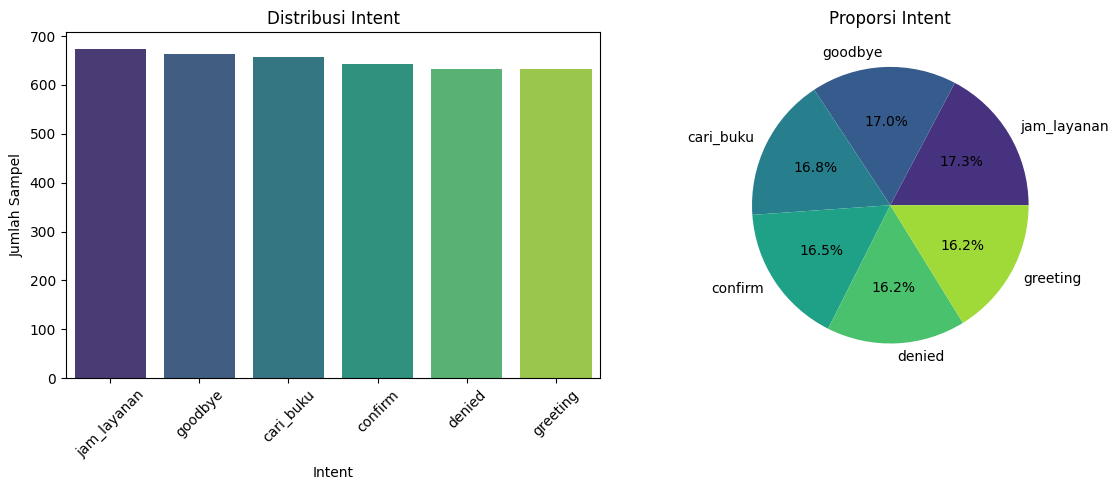


✅ Dataset telah dibagi: 3198 data training dan 703 data validasi
Memuat model IndoBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil dimuat
Menyiapkan dataset...
Menggunakan class weights: [0.98886827 1.01330798 1.02697495 0.98158379 1.02895753 0.96383363]
Menggunakan device: cuda
Mulai pelatihan model...
Total epoch: 10, batch size: 16, learning rate: 2e-05, weight decay: 0.01
Menggunakan Focal Loss dengan gamma=2.0

Epoch 1/10 - Training dimulai...


Epoch 1/10 - Validasi dimulai...


Epoch 1/10:
  Train Loss: 0.5870
  Val Loss: 0.2342, Val Accuracy: 83.78%
  Val F1: 0.8395, Val Precision: 0.8487, Val Recall: 0.8378

Class-wise precision/recall/F1 setelah epoch 1:
              precision    recall  f1-score   support

           0     0.9569    0.9407    0.9487       118
           1     0.7155    0.7155    0.7155       116
           2     0.9121    0.7281    0.8098       114
           3     0.7891    0.8417    0.8145       120
           4     0.7113    0.8860    0.7891       114
           5     1.0000    0.9091    0.9524       121

    accuracy                         0.8378       703
   macro avg     0.8475    0.8368    0.8383       703
weighted avg     0.8487    0.8378    0.8395       703

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntent2

Epoch 2/10 - Training dimulai...


Epoch 2/10 - Validasi dimulai...


Epoch 2/10:
  Train Loss: 0.1389
  Val Loss: 0.2030, Val Accuracy: 88.34%
  Val F1: 0.8836, Val Precision: 0.8924, Val Recall: 0.8834

Class-wise precision/recall/F1 setelah epoch 2:
              precision    recall  f1-score   support

           0     0.9831    0.9831    0.9831       118
           1     0.8586    0.7328    0.7907       116
           2     0.9020    0.8070    0.8519       114
           3     0.9182    0.8417    0.8783       120
           4     0.7171    0.9561    0.8195       114
           5     0.9672    0.9752    0.9712       121

    accuracy                         0.8834       703
   macro avg     0.8910    0.8826    0.8824       703
weighted avg     0.8924    0.8834    0.8836       703

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntent2

Epoch 3/10 - Training dimulai...


Epoch 3/10 - Validasi dimulai...


Epoch 3/10:
  Train Loss: 0.0366
  Val Loss: 0.1880, Val Accuracy: 91.32%
  Val F1: 0.9141, Val Precision: 0.9181, Val Recall: 0.9132

Class-wise precision/recall/F1 setelah epoch 3:
              precision    recall  f1-score   support

           0     0.9831    0.9831    0.9831       118
           1     0.7895    0.9052    0.8434       116
           2     0.8860    0.8860    0.8860       114
           3     0.9709    0.8333    0.8969       120
           4     0.8803    0.9035    0.8918       114
           5     0.9915    0.9669    0.9791       121

    accuracy                         0.9132       703
   macro avg     0.9169    0.9130    0.9134       703
weighted avg     0.9181    0.9132    0.9141       703

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntent2

Epoch 4/10 - Training dimulai...


Epoch 4/10 - Validasi dimulai...


Epoch 4/10:
  Train Loss: 0.0144
  Val Loss: 0.1771, Val Accuracy: 93.03%
  Val F1: 0.9303, Val Precision: 0.9311, Val Recall: 0.9303

Class-wise precision/recall/F1 setelah epoch 4:
              precision    recall  f1-score   support

           0     0.9669    0.9915    0.9791       118
           1     0.8560    0.9224    0.8880       116
           2     0.9279    0.9035    0.9156       114
           3     0.9469    0.8917    0.9185       120
           4     0.9189    0.8947    0.9067       114
           5     0.9672    0.9752    0.9712       121

    accuracy                         0.9303       703
   macro avg     0.9307    0.9298    0.9298       703
weighted avg     0.9311    0.9303    0.9303       703

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntent2

Epoch 5/10 - Training dimulai...


Epoch 5/10 - Validasi dimulai...


Epoch 5/10:
  Train Loss: 0.0084
  Val Loss: 0.2090, Val Accuracy: 91.47%
  Val F1: 0.9149, Val Precision: 0.9182, Val Recall: 0.9147

Class-wise precision/recall/F1 setelah epoch 5:
              precision    recall  f1-score   support

           0     0.9833    1.0000    0.9916       118
           1     0.7941    0.9310    0.8571       116
           2     0.9327    0.8509    0.8899       114
           3     0.9369    0.8667    0.9004       120
           4     0.8909    0.8596    0.8750       114
           5     0.9672    0.9752    0.9712       121

    accuracy                         0.9147       703
   macro avg     0.9175    0.9139    0.9142       703
weighted avg     0.9182    0.9147    0.9149       703

Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 6/10 - Training dimulai...


Epoch 6/10 - Validasi dimulai...


Epoch 6/10:
  Train Loss: 0.0014
  Val Loss: 0.2135, Val Accuracy: 92.03%
  Val F1: 0.9204, Val Precision: 0.9223, Val Recall: 0.9203

Class-wise precision/recall/F1 setelah epoch 6:
              precision    recall  f1-score   support

           0     0.9752    1.0000    0.9874       118
           1     0.8547    0.8621    0.8584       116
           2     0.9174    0.8772    0.8969       114
           3     0.9630    0.8667    0.9123       120
           4     0.8425    0.9386    0.8880       114
           5     0.9752    0.9752    0.9752       121

    accuracy                         0.9203       703
   macro avg     0.9213    0.9200    0.9197       703
weighted avg     0.9223    0.9203    0.9204       703

Validation loss tidak membaik. Early stopping counter: 2/3

Epoch 7/10 - Training dimulai...


Epoch 7/10 - Validasi dimulai...


Epoch 7/10:
  Train Loss: 0.0004
  Val Loss: 0.2157, Val Accuracy: 91.75%
  Val F1: 0.9174, Val Precision: 0.9187, Val Recall: 0.9175

Class-wise precision/recall/F1 setelah epoch 7:
              precision    recall  f1-score   support

           0     0.9832    0.9915    0.9873       118
           1     0.8359    0.9224    0.8770       116
           2     0.9333    0.8596    0.8950       114
           3     0.8983    0.8833    0.8908       120
           4     0.9000    0.8684    0.8839       114
           5     0.9593    0.9752    0.9672       121

    accuracy                         0.9175       703
   macro avg     0.9184    0.9168    0.9169       703
weighted avg     0.9187    0.9175    0.9174       703

Validation loss tidak membaik. Early stopping counter: 3/3
Early stopping triggered setelah 7 epochs
Pelatihan selesai! Model terbaik disimpan di /content/drive/MyDrive/RusdiIntent2
Enhanced training history saved to /content/drive/MyDrive/RusdiIntent2/enhanced_training_his

Calibrating OOD detection: 100%|██████████| 44/44 [00:04<00:00,  9.56it/s]


Energy threshold: -4.0413
MSP threshold: 0.6914
OOD thresholds saved at /content/drive/MyDrive/RusdiIntent2/ood_thresholds.json


Evaluasi Model: 100%|██████████| 44/44 [00:04<00:00,  9.46it/s]



Model Evaluation Report:
Overall Accuracy: 0.9175
Macro F1-score: 0.9169
Weighted F1-score: 0.9174
Enhanced training history saved to /content/drive/MyDrive/RusdiIntent2/enhanced_training_history.json

✅ Model telah berhasil dilatih dan disimpan di /content/drive/MyDrive/RusdiIntent2
Jumlah intent: 6
Intent yang didukung: cari_buku, confirm, denied, goodbye, greeting, jam_layanan
OOD detection thresholds: Energy=-4.0413, MSP=0.6914
Visualisasi training telah disimpan di /content/drive/MyDrive/RusdiIntent2
- Interactive plots dapat dibuka pada file HTML di folder tersebut
- Static plots tersedia dalam format PNG
OOD thresholds loaded: Energy=-4.0413, MSP=0.6914
Menggunakan metode deteksi OOD: combined

Demo Prediksi Intent dengan Enhanced OOD Detection:

Mode Interaktif - Masukkan teks untuk prediksi intent
Ketik 'exit' untuk keluar
----------------------------

Masukkan teks: buaya putih sungai musi
✓ Intent terdeteksi: greeting (confidence: 0.9214)

Top 3 intent:
  1. greeting: 0.921

In [38]:
# Cell 13: Jalankan pipeline (uncomment untuk menjalankan)

model, tokenizer, intent_classes, label_encoder = run_full_pipeline_enhanced(
    use_drive=True,               # Whether to use Google Drive for storage
    percentile=95,                # Percentile for OOD threshold
    ood_method='combined',        # OOD detection method ('msp', 'energy', or 'combined')
    split_dataset="yes",           # "yes" for splitting train.csv, "no" for separate files
    val_split=0.18                 # Validation split ratio if split_dataset="yes"
)


# Cell 14: Jalankan demo prediksi (uncomment untuk menjalankan)


In [34]:
# @title Teks judul default
test_sentences = [
    # GREETING
    "Halo, selamat pagi!",
    "Apa kabar?",
    "Hai, bot!",
    "Permisi, boleh bertanya?",
    "Yo, ada orang di sana?",

    # GOODBYE
    "Terima kasih, sampai jumpa.",
    "Ok, saya pergi dulu.",
    "Sampai nanti!",
    "Dadah, bot.",
    "Aku akan kembali nanti.",

    # CONFIRM
    "Iya, benar.",
    "Betul sekali.",
    "Ya, saya setuju.",
    "Tentu saja.",
    "Itu yang saya maksud.",

    # DENIED
    "Tidak, bukan itu.",
    "Salah.",
    "Bukan, maksud saya yang lain.",
    "Enggak.",
    "Saya tidak yakin dengan itu.",

    # AMBIGUOUS (bisa mengecoh)
    "Saya rasa tidak perlu, tapi ya juga boleh.",
    "Mungkin... tapi entahlah.",
    "Terserah kamu aja deh.",
    "Boleh iya, boleh juga tidak.",
    "Ya tapi tidak juga sih...",
    "p",
    "test",
    "y",
    "g",
    "N"
]


In [35]:
# @title Teks judul default
# If you want to load an existing model and run predictions
run_prediction_demo_enhanced(
    model_path=MODEL_SAVE_PATH,  # Your MODEL_SAVE_PATH
    method='combined',  # Which OOD detection method to use
    test_texts=test_sentences
)

Memuat model dari /content/drive/MyDrive/RusdiIntent2...
Intent yang didukung: cari_buku, confirm, denied, goodbye, greeting, jam_layanan
OOD thresholds loaded: Energy=-4.0781, MSP=0.7226
Menggunakan metode deteksi OOD: combined

Demo Prediksi Intent dengan Enhanced OOD Detection:

Memprediksi 30 contoh teks:
----------------------------

Contoh #1: "Halo, selamat pagi!"
✓ Intent terdeteksi: greeting (confidence: 0.9000)

Top 3 intent:
  1. greeting: 0.9000
  2. goodbye: 0.0604
  3. denied: 0.0172

Detail OOD detection:
  Energy-based: OOD (-3.7472)
  MSP-based: In-Distribution (0.9000)
  Final decision: In-Distribution

Contoh #2: "Apa kabar?"
✓ Intent terdeteksi: greeting (confidence: 0.9477)

Top 3 intent:
  1. greeting: 0.9477
  2. goodbye: 0.0383
  3. confirm: 0.0052

Detail OOD detection:
  Energy-based: In-Distribution (-4.3910)
  MSP-based: In-Distribution (0.9477)
  Final decision: In-Distribution

Contoh #3: "Hai, bot!"
✓ Intent terdeteksi: greeting (confidence: 0.9432)

Top 

In [36]:
import pandas as pd
import random
import re
import nltk
import torch
from nltk.corpus import wordnet
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from fuzzywuzzy import fuzz
from tqdm import tqdm
import time
import os
from collections import defaultdict, Counter

# Download WordNet data (if not already downloaded)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# === KONFIGURASI ===
INPUT_FILE = '/content/train.xlsx'  # Bisa CSV atau XLSX
OUTPUT_CSV = 'augmented_datasets.csv'
MIN_AUGMENTATIONS_PER_SAMPLE = 3  # Minimum augmentations per original sample
MAX_AUGMENTATIONS_PER_SAMPLE = 7  # Maximum augmentations per original sample
TARGET_SAMPLES_PER_CLASS = 700    # Target number of samples per class
USE_PARAPHRASE = True             # aktifkan atau matikan paraphrase
BATCH_SIZE = 16                   # For batch processing

print("Loading dataset...")
# === BACA DATASET (CSV atau XLSX) ===
file_ext = os.path.splitext(INPUT_FILE)[1].lower()

if file_ext == '.xlsx':
    print(f"Detected Excel file: {INPUT_FILE}")
    df = pd.read_excel(INPUT_FILE)
    # Buat file CSV sementara untuk kompatibilitas
    csv_path = INPUT_FILE.replace('.xlsx', '.csv')
    df.to_csv(csv_path, index=False)
    print(f"Converted Excel file to CSV: {csv_path}")
    INPUT_FILE = csv_path
elif file_ext == '.csv':
    print(f"Detected CSV file: {INPUT_FILE}")
    df = pd.read_csv(INPUT_FILE)
else:
    raise ValueError(f"Unsupported file format: {file_ext}. Please provide a CSV or XLSX file.")

df = df.dropna()
print(f"Dataset loaded with {len(df)} rows")

# Count samples per intent class
intent_counts = Counter(df['intent'])
print("Original class distribution:")
for intent, count in intent_counts.items():
    print(f"  {intent}: {count}")

# Calculate augmentation factors for each class
augmentation_factors = {}
for intent, count in intent_counts.items():
    # Calculate how many times each sample needs to be augmented on average
    if count >= TARGET_SAMPLES_PER_CLASS:
        augmentation_factors[intent] = 1  # Minimum augmentation factor
    else:
        factor = max(1, min(10, TARGET_SAMPLES_PER_CLASS / count))
        augmentation_factors[intent] = factor

print("\nAugmentation factors:")
for intent, factor in augmentation_factors.items():
    print(f"  {intent}: {factor:.2f}x")

# === INDO PARAPHRASE SETUP ===
if USE_PARAPHRASE:
    print("Loading paraphrase model...")
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained("Wikidepia/IndoT5-base-paraphrase")
    model = AutoModelForSeq2SeqLM.from_pretrained("Wikidepia/IndoT5-base-paraphrase")

    # Move model to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Model loaded in {time.time() - start_time:.2f} seconds. Using device: {device}")

# Batch processing for paraphrasing
def batch_paraphrase(sentences, batch_size=BATCH_SIZE):
    if not sentences:
        return []

    device = next(model.parameters()).device
    results = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(["paraphrase: " + text + " </s>" for text in batch],
                         padding='longest', truncation=True, max_length=128,
                         return_tensors="pt").to(device)

        with torch.no_grad():  # Disable gradient calculation for inference
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                do_sample=True,
                top_k=200,
                top_p=0.95,
                early_stopping=True,
                num_return_sequences=1
            )

        decoded = [tokenizer.decode(outputs[j], skip_special_tokens=True)
                  for j in range(len(outputs))]
        results.extend(decoded)

    return results

# === INTENT-SPECIFIC SLANG DICTIONARIES ===
# Common slang across all intents
common_slang = {
    'tidak': 'gak',
    'ga': 'gx',
    'bukan': 'bkn',
    'apakah': 'apkh',
    'bagaimana': 'gmn',
    'ya': 'iya',
    'benar': 'bener',
    'oke': 'ok',
    'baik': 'sip',
    'boleh': 'blh',
    'bisa': 'bs',
    'tolong': 'tlg',
    'saya': 'aku',
    'sekarang': 'skrg',
}

# Intent-specific slang dictionaries
intent_slang = {
    'jam_layanan': {
        'perpustakaan': 'perpus',
        'buka': 'open',
        'tutup': 'close',
        'sampai': 'sampe',
        'jam': 'jm',
        'informasi': 'info',
        'hari ini': 'hr ini',
        'kapan': 'kpn',
        'jadwal': 'jdwl',
        'operasional': 'ops',
        'layanan': 'lyn',
        'masih': 'msih',
        'minggu': 'mg',
        'hari': 'hri',
        'pukul': 'pkl',
    },
    'cari_buku': {
        'mencari': 'nyari',
        'mau mencari': 'mau nyari',
        'ingin mencari': 'pengen nyari',
        'tolong carikan': 'cariin',
        'tolong bantu cari': 'bantuin cari',
        'mencarikan': 'cariin',
        'buku': 'book',
        'butuh': 'need',
        'melihat': 'liat',
        'daftar': 'list',
        'akses': 'akses',
        'temukan': 'nemu',
        'mencoba': 'nyoba',
        'mengakses': 'akses',
        'gunakan': 'make use',
        'fitur': 'fitr',
        'pencarian': 'search',
        'referensi': 'ref',
        'bantuan': 'bntuan',
        'dimana': 'dmn',
        'cek': 'check',
        'lihat-lihat': 'liat2',
        'cari': 'search',
        'mencari buku': 'nyari book',
    },
    'greeting': {
        'halo': 'haloo',
        'hai': 'hay',
        'hello': 'helo',
        'selamat pagi': 'slmt pagi',
        'selamat siang': 'slmt siang',
        'selamat sore': 'slmt sore',
        'selamat malam': 'slmt malam',
        'apa kabar': 'apa kbr',
        'assalamualaikum': 'asswrwb',
        'permisi': 'permizz',
        'hai bot': 'hey bot',
        'bot': 'bt',
        'selamat datang': 'slmt dtg',
        # Additional variations for greeting
        'halo selamat pagi': 'hai morning',
        'hai selamat siang': 'helo siang',
        'met pagi': 'morning',
        'pagi': 'pgi',
        'siang': 'siang boss',
    },
    'goodbye': {
        'terima kasih': 'makasih',
        'goodbye': 'gudbai',
        'makasih': 'mksh',
        'makasih ya': 'thx ya',
        'sampai jumpa': 'sampe jmpa',
        'dadah': 'daah',
        'bye': 'byee',
        'sampai nanti': 'sampe ntar',
        'see you': 'cu',
        'thanks': 'thx',
        'thank you': 'tq',
        'sekian': 'skian',
        'itu saja': 'itu aj',
        # Additional variations for goodbye
        'ok makasih': 'ok thx',
        'terima kasih banyak': 'thanks banget',
        'makasih atas bantuannya': 'thx for helping',
        'sampai bertemu lagi': 'see u later',
        'selamat tinggal': 'bye bye',
    },
    'confirm': {
        'betul': 'btl',
        'setuju': 'stju',
        'bener': 'bnr',
        'iya benar': 'ya bnr',
        'okey': 'okeyy',
        'ok deh': 'okedeh',
        # Additional variations for confirm
        'tentu saja': 'tentu',
        'saya setuju': 'aku setuju',
        'benar sekali': 'bener banget',
        'ya betul': 'yup betul',
        'tentu boleh': 'boleh dong',
        'setuju sekali': 'sangat setuju',
    },
    'denied': {
        'tidak mau': 'gak mau',
        'ga mau': 'gk mw',
        'tidak setuju': 'gak setuju',
        'saya tidak': 'aku ga',
        'nggak perlu': 'ga perlu',
        'ga usah': 'rasah',
        'tidak perlu': 'gak usah',
        'no': 'nope',
        # Additional variations for denied
        'saya tidak setuju': 'aku gak setuju',
        'tidak bisa': 'ga bisa',
        'tidak boleh': 'gak boleh',
        'jangan': 'jgn',
        'maaf tidak': 'sorry no',
        'tidak begitu': 'gak gitu',
    }
}

# Function to combine common slang with intent-specific slang
def get_slang_dict(intent):
    combined = common_slang.copy()
    if intent in intent_slang:
        combined.update(intent_slang[intent])
    return combined

# === SINONIM (WordNet) with caching ===
synonym_cache = {}

def synonym_replace(text, intensity=1.0):
    """Replace words with synonyms with controllable intensity"""
    words = text.split()
    new_words = []

    replace_prob = min(0.8, intensity * 0.4)  # Scale replacement probability with intensity

    for word in words:
        if word in synonym_cache:
            if random.random() < replace_prob:
                new_words.append(synonym_cache[word])
            else:
                new_words.append(word)
            continue

        if len(word) > 3 and random.random() < replace_prob:  # Only process words longer than 3 chars
            syns = wordnet.synsets(word)
            if syns:
                lemmas = set(l.name().replace('_', ' ') for s in syns for l in s.lemmas())
                if lemmas:
                    synonym = random.choice(list(lemmas))
                    if synonym.lower() != word.lower():
                        synonym_cache[word] = synonym
                        new_words.append(synonym)
                        continue

        synonym_cache[word] = word  # Cache the original word if no synonym found
        new_words.append(word)

    return ' '.join(new_words)

# === SLANG REPLACEMENT with intent-specific patterns ===
slang_patterns_by_intent = {}

def compile_slang_patterns(intent):
    if intent not in slang_patterns_by_intent:
        slang_dict = get_slang_dict(intent)
        slang_patterns_by_intent[intent] = {
            re.compile(rf'\b{k}\b', re.IGNORECASE): v for k, v in slang_dict.items()
        }
    return slang_patterns_by_intent[intent]

def apply_slang_typo(text, intent, intensity=1.0):
    """Apply slang replacements with controllable intensity"""
    patterns = compile_slang_patterns(intent)

    # Apply only some of the patterns based on intensity
    patterns_to_use = random.sample(
        list(patterns.items()),
        k=int(len(patterns) * min(1.0, intensity * 0.7))
    )

    for pattern, replacement in patterns_to_use:
        text = pattern.sub(replacement, text)
    return text

# Character-level augmentation
def character_noise(text, intensity=1.0):
    """Add typos like character swaps, insertions, deletions"""
    chars = list(text)
    swap_prob = min(0.1, intensity * 0.05)  # Scale probability with intensity

    # Character swaps
    for i in range(len(chars)-1):
        if random.random() < swap_prob:
            chars[i], chars[i+1] = chars[i+1], chars[i]

    return ''.join(chars)

# Word-level augmentation for short texts
def short_text_augmentation(text, intent):
    """Special augmentation for very short texts like greetings and goodbyes"""
    # For very short texts, add filler words or expressions
    fillers = {
        'greeting': ['', ' ya', ' kak', ' min', ' gan', ' bro', ' sis', ' admin', '!', '!!'],
        'goodbye': ['', ' ya', ' kak', ' min', ' sekali lagi', ' semuanya', '!', '!!'],
        'confirm': ['', ' kok', ' dong', ' banget', ' sih', ' tentu', ' lah', '!', '!!'],
        'denied': ['', ' sih', ' kok', ' ah', ' deh', ' lah', '!', '!!'],
    }

    if intent in fillers and len(text.split()) <= 3:
        # Add 0-2 random fillers
        num_fillers = random.randint(0, 2)
        for _ in range(num_fillers):
            text += random.choice(fillers[intent])

    return text

# Combined augmentation
def augment_text(text, intent, intensity=1.0):
    """Apply multiple augmentation techniques based on class needs"""
    result = text

    # Choose augmentation methods based on text length and intent
    text_length = len(text.split())

    if text_length <= 3:  # Very short text
        # For short texts, focus on slang and special augmentations
        methods = random.sample([
            'slang', 'slang', 'short_text', 'char_noise', 'synonym'
        ], k=min(3, int(intensity * 3)))
    else:  # Longer text
        methods = random.sample([
            'slang', 'synonym', 'char_noise'
        ], k=min(3, int(intensity * 2)))

    # Apply selected methods
    for method in methods:
        if method == 'slang':
            result = apply_slang_typo(result, intent, intensity)
        elif method == 'synonym':
            result = synonym_replace(result, intensity)
        elif method == 'char_noise':
            result = character_noise(result, intensity)
        elif method == 'short_text':
            result = short_text_augmentation(result, intent)

    return result

# Fungsi untuk mengecek dan menyeimbangkan jumlah sampel per kelas
def balance_samples(results_by_intent, target_samples_per_class):
    """
    Menyeimbangkan jumlah sampel per kelas dengan:
    1. Mempertahankan semua sampel asli
    2. Menambahkan augmentasi hingga target tercapai
    3. Batasi sampel berlebih jika melebihi target
    """
    balanced_results = defaultdict(list)

    # Untuk setiap intent
    for intent, samples in results_by_intent.items():
        current_count = len(samples)

        if current_count <= target_samples_per_class:
            # Jika jumlah sampel kurang dari target, gunakan semua
            balanced_results[intent] = samples
        else:
            # Jika lebih dari target, ambil sample secara acak
            # Pastikan 20% pertama adalah data asli (untuk mempertahankan kualitas)
            orig_count = min(int(target_samples_per_class * 0.2), intent_counts[intent])

            # Ambil semua sampel asli hingga batas orig_count
            balanced_results[intent] = samples[:orig_count]

            # Ambil sampel augmentasi secara acak untuk sisa target
            remaining_slots = target_samples_per_class - orig_count
            if remaining_slots > 0:
                # Acak sisa sampel dan ambil sebanyak remaining_slots
                remaining_samples = samples[orig_count:]
                if remaining_samples:
                    random.shuffle(remaining_samples)
                    balanced_results[intent].extend(remaining_samples[:remaining_slots])

    return balanced_results

# === AUGMENTATION PROCESS ===
print("Starting balanced augmentation...")
start_time = time.time()

augmented_results = defaultdict(list)
paraphrase_candidates = defaultdict(list)

# First, add all original data
for _, row in df.iterrows():
    intent = row['intent']
    text = row['text']
    augmented_results[intent].append(text)

# Then determine augmentation targets for each class
for intent, factor in augmentation_factors.items():
    original_count = intent_counts[intent]

    # For each original sample in this intent
    intent_df = df[df['intent'] == intent]
    for idx, row in intent_df.iterrows():
        text = row['text']

        # Calculate augmentations needed for this sample
        num_augmentations = max(
            MIN_AUGMENTATIONS_PER_SAMPLE,
            min(MAX_AUGMENTATIONS_PER_SAMPLE, int(factor * 2))
        )

        # Regular augmentations
        for _ in range(num_augmentations):
            # Higher intensity for smaller classes
            intensity = 1.0 + (factor - 1) * 0.5  # Scale 1.0-5.0 based on factor
            aug_text = augment_text(text, intent, intensity)

            if aug_text.lower() != text.lower():
                augmented_results[intent].append(aug_text)

        # Add sample for paraphrasing if enabled
        if USE_PARAPHRASE:
            # More paraphrasing for under-represented classes
            paraphrase_prob = min(0.9, factor * 0.2)
            if random.random() < paraphrase_prob:
                paraphrase_candidates[intent].append(text)

# Process paraphrases in batches by intent
if USE_PARAPHRASE:
    for intent, sentences in paraphrase_candidates.items():
        if not sentences:
            continue

        print(f"Paraphrasing {len(sentences)} sentences for intent '{intent}'...")
        paraphrased = batch_paraphrase(sentences)

        # Add paraphrased results
        for original, paraphrase in zip(sentences, paraphrased):
            if original.lower() != paraphrase.lower():
                augmented_results[intent].append(paraphrase)

# Sekarang kita pastikan distribusi kelas seimbang
print("Balancing class distribution...")
balanced_results = balance_samples(augmented_results, TARGET_SAMPLES_PER_CLASS)

# Combine all results
final_results = []
for intent, texts in balanced_results.items():
    for text in texts:
        final_results.append((intent, text))

# === SIMPAN HASIL ===
print("Final class distribution:")
result_counts = defaultdict(int)
for intent, _ in final_results:
    result_counts[intent] += 1

for intent, count in result_counts.items():
    print(f"  {intent}: {count}")

aug_df = pd.DataFrame(final_results, columns=['intent', 'text'])
aug_df.drop_duplicates(subset=['text'], keep='first', inplace=True)
aug_df.to_csv(OUTPUT_CSV, index=False)

print(f"[✓] Selesai dalam {time.time() - start_time:.2f} detik!")
print(f"Original: {len(df)} | Total setelah augmentasi: {len(aug_df)} → {OUTPUT_CSV}")

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



Loading dataset...
Detected Excel file: /content/train.xlsx
Converted Excel file to CSV: /content/train.csv
Dataset loaded with 666 rows
Original class distribution:
  greeting: 106
  goodbye: 112
  confirm: 104
  denied: 104
  jam_layanan: 120
  cari_buku: 120

Augmentation factors:
  greeting: 6.60x
  goodbye: 6.25x
  confirm: 6.73x
  denied: 6.73x
  jam_layanan: 5.83x
  cari_buku: 5.83x
Loading paraphrase model...


tokenizer_config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/777k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Model loaded in 15.19 seconds. Using device: cuda
Starting balanced augmentation...


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Paraphrasing 92 sentences for intent 'greeting'...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning:

`num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.



Paraphrasing 102 sentences for intent 'goodbye'...
Paraphrasing 93 sentences for intent 'confirm'...
Paraphrasing 92 sentences for intent 'denied'...
Paraphrasing 108 sentences for intent 'jam_layanan'...
Paraphrasing 110 sentences for intent 'cari_buku'...
Balancing class distribution...
Final class distribution:
  greeting: 700
  goodbye: 700
  confirm: 700
  denied: 700
  jam_layanan: 700
  cari_buku: 700
[✓] Selesai dalam 20.67 detik!
Original: 666 | Total setelah augmentasi: 3901 → augmented_datasets.csv


In [ ]:
!pip install transformers nltk fuzzywuzzy python-Levenshtein

In [ ]:
# @title kontol
import pandas as pd
import random
import nltk
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
from collections import defaultdict
import re

# =========[ IMPROVED SYNONYM DICTIONARY ]=========
# Custom Indonesian synonym dictionary for common words
id_synonyms = {
    # Greeting related words
    "saya": ["aku", "gue", "gua", "hamba", "beta"],
    "kamu": ["anda", "engkau", "kalian", "elu", "dikau"],
    "halo": ["hai", "hey", "hi", "selamat jumpa", "salam", "assalamualaikum"],
    "selamat": ["bahagia", "sukses", "sejahtera"],
    "senang": ["bahagia", "gembira", "ceria", "suka", "girang"],
    "bertemu": ["berjumpa", "ketemu", "bersua", "menjumpai"],
    "rindu": ["kangen", "merindukan", "nostalgia", "damba"],

    # Goodbye related words
    "sampai": ["hingga", "sampai dengan", "sehingga"],
    "jumpa": ["ketemu", "bersua", "bertemu", "berjumpa"],
    "pamit": ["izin", "permisi", "undur diri", "mohon diri"],
    "tinggal": ["berdiam", "bermukim", "menetap"],
    "pergi": ["berangkat", "meninggalkan", "menuju", "bepergian"],
    "pulang": ["kembali", "balik", "mudik", "kembali ke rumah"],

    # Confirm related words
    "ya": ["iya", "benar", "betul", "sungguh", "memang"],
    "setuju": ["sepakat", "akur", "mufakat", "sependapat", "sepaham"],
    "benar": ["betul", "tepat", "akurat", "sahih", "valid"],
    "sudah": ["telah", "usai", "selesai", "rampung", "beres"],
    "bisa": ["mampu", "dapat", "sanggup", "berdaya", "berkemampuan"],
    "pasti": ["tentu", "yakin", "meyakinkan", "positif", "terang"],
    "siap": ["bersedia", "bersiap", "sedia", "bersiaga", "tersedia"],
    "jadi": ["menjadi", "terlaksana", "terjadi", "berlangsung"],
    "lanjut": ["terus", "melanjutkan", "meneruskan", "berlanjut"],
    "mantap": ["hebat", "bagus", "keren", "mengagumkan", "luar biasa"],
    "bagus": ["baik", "indah", "elok", "cantik", "menarik"],
    "tentu": ["pasti", "yakin", "meyakinkan", "terang", "jelas"],

    # Denied related words
    "tidak": ["bukan", "tiada", "tak", "belum", "tanpa"],
    "jangan": ["larang", "cegah", "hindari", "batalkan"],
    "belum": ["masih", "sedang", "tengah", "dalam proses"],
    "batal": ["urung", "gagal", "berhenti", "dibatalkan", "tak jadi"],
    "maaf": ["ampun", "pemaafan", "pengampunan", "mohon maaf"],
    "menolak": ["menampik", "mengelak", "menghindar", "melarang"],
    "mustahil": ["tidak mungkin", "tidak bisa", "sulit", "sukar"],
    "salah": ["keliru", "alpa", "sesat", "khilaf", "menyimpang"],
    "gagal": ["batal", "tidak berhasil", "kalah", "tumbang"],
    "susah": ["sulit", "rumit", "kompleks", "tidak mudah", "berat"],

    # Common words
    "tolong": ["bantu", "sokong", "dukung", "membantu"],
    "besok": ["esok", "hari berikutnya", "keesokan hari"],
    "cukup": ["memadai", "layak", "pantas", "patut", "lumayan"],
    "untuk": ["bagi", "demi", "guna", "buat", "kepada"],
    "ini": ["hal ini", "hal tersebut", "sekarang", "saat ini"],
    "kita": ["kami", "kamu dan saya", "kelompok kita", "tim kita"],
    "fix": ["tetap", "pasti", "permanen", "tidak berubah"],
    "nigga": ["nigger", "hitam", "negro"]

}

# =========[ FILE PATHS ]=========
PilihData = "train"  # @param ["train","val"]
if PilihData == "train":
    file_path = "/content/rusdi-prototype-1/val.xlsx"
    csv_path = "/content/train.csv"
    output_path_balanced = "/content/train.csv"
elif PilihData == "val":
    file_path = "/content/val.xlsx"
    csv_path = "/content/val.csv"
    output_path_balanced = "/content/val.csv"

# =========[ READ & CONVERT XLSX ]=========
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path)
    df.to_csv(csv_path, index=False)
    print(f"✅ File dikonversi ke CSV: {csv_path}")
else:
    df = pd.read_csv(file_path)

# =========[ AUGMENTATION METHODS ]=========

def get_better_synonym(word):
    """Get synonym from custom dictionary or return the original word"""
    word_lower = word.lower()
    if word_lower in id_synonyms:
        synonyms = id_synonyms[word_lower]
        return random.choice(synonyms)
    return word

def replace_with_synonym(sentence):
    """Replace words with synonyms while preserving capitalization"""
    words = sentence.split()
    new_words = []

    for word in words:
        synonym = get_better_synonym(word)
        # Preserve capitalization
        if word and word[0].isupper() and synonym:
            synonym = synonym[0].upper() + synonym[1:]
        new_words.append(synonym)

    return " ".join(new_words)

def back_translate(sentence):
    """Translate to English and back to Indonesian"""
    try:
        # First to English
        translated = GoogleTranslator(source='id', target='en').translate(sentence)
        # Then back to Indonesian
        back_translated = GoogleTranslator(source='en', target='id').translate(translated)

        # Only return if result is different but not completely unrelated
        if back_translated != sentence and len(back_translated.split()) >= len(sentence.split()) * 0.5:
            return back_translated
        return sentence
    except Exception:
        return sentence

def add_typo(sentence):
    """Add a single typo by replacing a character"""
    chars = list(sentence)
    if len(chars) > 3:
        idx = random.randint(0, len(chars) - 1)
        if chars[idx].isalpha():  # Only replace letters
            chars[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

def random_deletion(sentence, p=0.2):
    """Delete words with probability p"""
    words = sentence.split()
    if len(words) <= 3:  # Don't delete from very short sentences
        return sentence

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)

    # Make sure we don't delete everything
    if not new_words:
        return sentence

    return " ".join(new_words)

def random_swap(sentence, n=1):
    """Swap n pairs of words"""
    words = sentence.split()
    if len(words) < 2:
        return sentence

    for _ in range(min(n, len(words)//2)):  # Ensure we don't try too many swaps
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)

def phonetic_augmentation(sentence):
    """Apply phonetic substitutions common in Indonesian chat"""
    phonetic_dict = {
        # Greeting related
        "saya": ["sy", "saia", "ane", "ana", "w", "gw", "q", "aq"],
        "kamu": ["km", "kamyu", "u", "lo", "lu", "l", "ngana", "sampeyan", "antum", "ente"],
        "halo": ["hlo", "hallo", "helo", "haloo", "hellow", "hy", "hyy", "p", "ping"],
        "selamat": ["slmt", "slamat", "met", "slam"],
        "pagi": ["pgi", "morning", "pg", "subuh"],
        "siang": ["siang", "afternoon", "siank", "siyang"],
        "malam": ["mlm", "malem", "mlem", "night", "evening", "mlem", "mlm"],
        "apa": ["ap", "ape", "apah", "pa"],
        "kabar": ["kbr", "kabare", "kbar", "kabbar"],
        "gimana": ["gmn", "bgmn", "gmana", "gimane", "gmn"],

        # Goodbye related
        "sampai": ["smp", "sampe", "smpe", "smpei", "sampeyan"],
        "jumpa": ["jpa", "jmpa", "ktmu", "jumpe"],
        "dadah": ["byebye", "bye", "bay", "byee", "bbye", "bye2", "dadah"],
        "pamit": ["pmt", "pamitt", "off", "out", "cabut", "cbut"],
        "tinggal": ["tgl", "tnggal", "tinggel", "tggal", "tinggelin"],
        "duluan": ["dlu", "duluan", "dluan", "dluan ya", "ahead"],
        "pergi": ["pgi", "pegi", "prgi", "out", "keluar"],
        "pulang": ["plg", "plng", "balik", "blk", "mudik"],

        # Confirm related
        "ya": ["y", "yah", "iye", "yoi", "yups", "yes", "yess", "yesss", "okey", "okeh", "oks"],
        "setuju": ["stju", "acc", "accept", "approved", "approve", "deal", "oke", "ok", "sip"],
        "benar": ["bnr", "bner", "bener", "bnr", "yoi", "correct"],
        "sudah": ["sdh", "dah", "udh", "done", "wes", "uwes", "udah", "sdah"],
        "bisa": ["bs", "bsa", "biza", "bsa", "biza", "ok"],
        "pasti": ["pst", "psti", "pastii", "sure", "certain"],
        "siap": ["sp", "ready", "sip", "sp", "roger", "on", "online"],
        "jadi": ["jd", "jdi", "jdnya", "jdiin", "proceed"],
        "lanjut": ["lnjt", "lanjt", "next", "go"],
        "mantap": ["mntap", "mantab", "mntb", "top", "mantul", "josss", "kerennn"],
        "bagus": ["bgs", "bgus", "nice", "naiss", "keren", "top"],

        # Denied related
        "tidak": ["tdk", "gak", "ga", "g", "nggak", "ngga", "nope", "no", "kagak", "kaga", "kgk"],
        "jangan": ["jgn", "jngn", "don't", "dont", "jgn", "ga usah", "tdk usah", "gausa", "gausah"],
        "belum": ["blm", "blom", "belom", "not yet", "durung", "durong", "belm"],
        "batal": ["btl", "cancel", "cansel", "urungkan", "batalin", "gajadi"],
        "maaf": ["sorry", "sori", "maf", "maap", "maaaaf", "mrff", "sry", "srry"],
        "menolak": ["tlk", "reject", "decline", "dtolak", "nolak", "gak mau", "gamau"],
        "mustahil": ["impossible", "ga mungkin", "g mungkin", "tdk mungkin", "gak bs"],
        "salah": ["slh", "wrong", "error", "eror", "salh", "fail"],
        "gagal": ["ggl", "fail", "failed", "error", "gagak", "failll"],

        # Common words
        "terima": ["trma", "thanks", "thx", "trims", "tq", "tyvm", "makasih", "mksih"],
        "kasih": ["ksh", "ksih", "thx", "makasih", "mksih", "thanks"],
        "tolong": ["tlng", "help", "tlg", "tulung", "bantu", "bantuin"],
        "please": ["plz", "plis", "pliss", "plisss", "pliissss", "tolong"],
        "besok": ["bsk", "bsok", "besok", "tmrw", "esok", "besuk"],
        "waktu": ["wkt", "waktu", "time", "tm", "jam"],
        "cukup": ["ckp", "enough", "cukuppp", "cukups", "ckup"],
        "melihat": ["lihat", "liat", "look", "see", "watching", "ngeliat"],
        "alasan": ["alsan", "reason", "why", "alesan", "alsn"],
        "untuk": ["utk", "buat", "bwt", "4", "tuk", "2", "to"],
        "melakukan": ["lakukan", "do", "lakuin", "melakuin", "ngerjain"],
        "ini": ["ni", "this", "these", "iki", "nih", "ne"],
        "kita": ["kta", "we", "us", "w", "kt"],
        "hari": ["hr", "day", "hri", "days", "dayy", "harii"],
        "bro": ["broh", "brow", "brother", "mas", "bang", "bor", "omm"],
        "sis": ["sist", "sister", "mbak", "mba", "nte", "ceu", "teh"]
    }

    words = sentence.split()
    new_words = []

    for word in words:
        word_lower = word.lower()
        if word_lower in phonetic_dict:
            new_word = random.choice(phonetic_dict[word_lower])
            # Preserve capitalization
            if word and word[0].isupper():
                new_word = new_word[0].upper() + new_word[1:]
            new_words.append(new_word)
        else:
            new_words.append(word)

    return " ".join(new_words)

def add_common_phrase(sentence):
    """Add a common Indonesian chat phrase"""
    common_phrases = ["sih", "ya", "anjay", "dong", "cuy", "bro", "lah", "plis", "eh",
                      "nih", "gitu", "kan", "yah", "deh", "banget"]
    return sentence + " " + random.choice(common_phrases)

def validate_augmentation(original, augmented):
    """Validate if augmentation is reasonable"""
    # Check if augmentation is too different
    if len(augmented.split()) < len(original.split()) * 0.5:
        return False

    # Check if augmentation is just the original
    if augmented == original:
        return False

    # Check if augmentation contains too many non-Indonesian characters
    non_indo_pattern = re.compile(r'[^a-zA-Z0-9\s.,?!\'"-:;()[\]{}]')
    if len(non_indo_pattern.findall(augmented)) > 2:
        return False

    return True

# Combined augmentations
def augment_data(text):
    """Generate multiple augmentations for a text"""
    methods = [
        replace_with_synonym,
        back_translate,
        add_typo,
        random_deletion,
        random_swap,
        phonetic_augmentation,
        add_common_phrase
    ]

    augmented = set()
    for method in methods:
        try:
            result = method(text)
            if validate_augmentation(text, result):
                augmented.add(result)
        except Exception as e:
            print(f"Error applying {method.__name__}: {str(e)}")
            continue

    return list(augmented)

# =========[ BALANCED AUGMENTATION ]=========
target_aug_per_class = 700  # Can be changed (e.g., 100 augmented per class)
intent_buckets = defaultdict(list)

# Group original data by intent
for _, row in df.iterrows():
    intent_buckets[row['intent']].append(row['text'])

df_augmented_balanced = []

# Augment per class until target reached
for intent, texts in intent_buckets.items():
    current_aug_count = 0
    index = 0
    existing_aug_set = set()
    print(f"🔄 Augmenting class '{intent}'...")

    # Limit iterations to prevent infinite loops
    max_iterations = 1000
    iterations = 0

    while current_aug_count < target_aug_per_class and iterations < max_iterations:
        original_text = texts[index % len(texts)]
        augmented_variants = augment_data(original_text)

        for aug in augmented_variants:
            if aug not in existing_aug_set:
                df_augmented_balanced.append([aug, intent])
                existing_aug_set.add(aug)
                current_aug_count += 1
                if current_aug_count >= target_aug_per_class:
                    break

        index += 1
        iterations += 1

    print(f"  ✓ Added {current_aug_count} augmentations for '{intent}'")

# Combine original + augmented
df_original = df[['text', 'intent']]
df_augmented_balanced = pd.DataFrame(df_augmented_balanced, columns=["text", "intent"])
df_final = pd.concat([df_original, df_augmented_balanced], ignore_index=True)

# Save to CSV
df_final.to_csv(output_path_balanced, index=False)
print(f"\n✅ Augmentasi selesai dan dataset seimbang disimpan di: {output_path_balanced}")

# =========[ PLOTTING DISTRIBUTIONS ]=========
def plot_distribution(data, title):
    plt.figure(figsize=(8, 4))
    data['intent'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel("Intent")
    plt.ylabel("Jumlah Sampel")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Show before/after plots
print("\n📊 Distribusi Sebelum Augmentasi:")
plot_distribution(df_original, "Distribusi Intent Sebelum Augmentasi")

print("\n📊 Distribusi Setelah Augmentasi:")
plot_distribution(df_final, "Distribusi Intent Setelah Augmentasi (Seimbang)")

In [ ]:
# @title Teks judul default
import pandas as pd

# Load kedua dataset
df1 = pd.read_csv('/content/train.csv')
df2 = pd.read_csv('/content/new_augmented_datasets.csv')

# Gabungkan dua dataframe
df_combined = pd.concat([df1, df2], ignore_index=True)

# (Opsional) Cek hasil
print(df_combined.shape)
print(df_combined.head())

# Simpan hasil gabungan kalau perlu
df_combined.to_csv('dataset_gabungan.csv', index=False)


(1807, 2)
            text    intent
0          hallo  greeting
1           helo  greeting
2  selamat siang  greeting
3  selamat malam  greeting
4   selamat pagi  greeting


In [ ]:
# prompt: ubah ini ke csv /content/rusdi-prototype-1/train.xlsx

import pandas as pd

# Path to your Excel file
excel_file_path = "/content/train.xlsx"

# Path to save the CSV file
csv_file_path = "/content/train.csv"

try:
    # Read the Excel file into a pandas DataFrame
    df = pd.read_excel(excel_file_path)

    # Convert the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)  # index=False prevents writing row indices

    print(f"Successfully converted '{excel_file_path}' to '{csv_file_path}'")

except FileNotFoundError:
    print(f"Error: File not found at '{excel_file_path}'")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully converted '/content/train.xlsx' to '/content/train.csv'


In [ ]:
# @title Teks judul default
# prompt: the model already trained and saved to drive, but can i test the model without running thee training.

# Path ke folder model di Google Drive
model_path = "/content/drive/MyDrive/indobert_intent_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load intent classes
with open(f"{model_path}/intent_classes.pkl", "rb") as f:
    intent_classes = pickle.load(f)

# Load label encoder (jika diperlukan)
with open(f"{model_path}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


def predict_intent(text, model, tokenizer, intent_classes, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents


# Contoh penggunaan
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")



             intent                            text
count          3901                            3901
unique            6                            3901
top     jam_layanan  Ada fiutr buat nyari book gak?
freq            674                               1


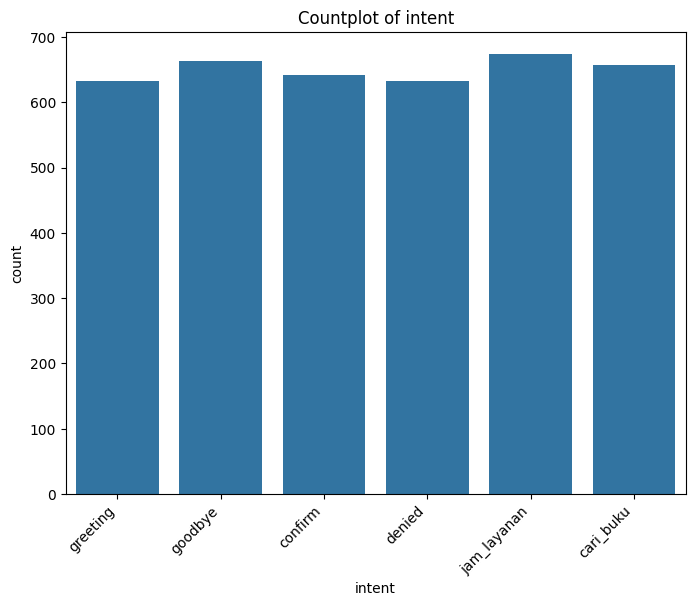

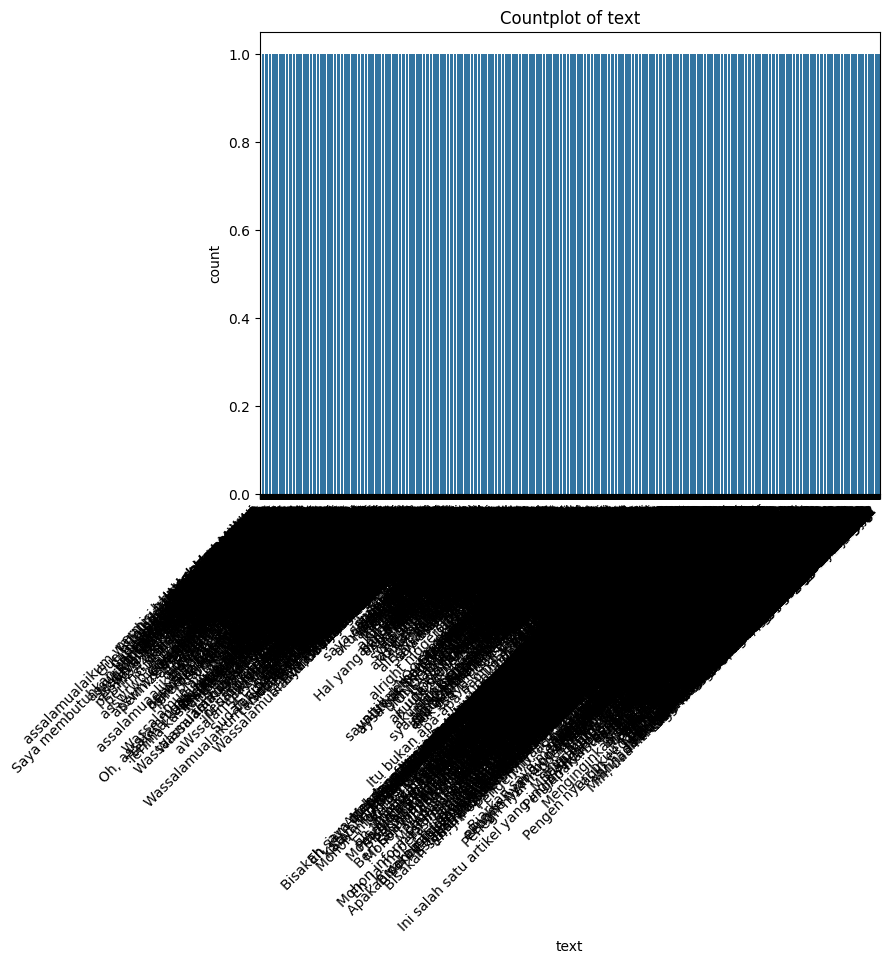

In [37]:
# prompt: visualisasi dataset distribution /content/augmented_datasets.csv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/augmented_datasets.csv')

# Display basic statistics
print(df.describe())

# Visualize the distribution of each column
for col in df.columns:
    plt.figure(figsize=(8, 6))
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
    else:
        sns.countplot(x=col, data=df)
        plt.title(f'Countplot of {col}')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

    plt.show()
